In [1]:
import psycopg2
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm_notebook as tqdm
from collections import OrderedDict

import json
import statistics

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score, mean_absolute_error, plot_roc_curve, average_precision_score, plot_precision_recall_curve

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 4

import pickle

%matplotlib inline

tqdm.pandas()

/Users/tim/miniconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
input_data = pickle.load(open('exploded.pickle', 'rb'))

In [21]:
all_data = input_data["x"]
discharge_days = input_data["y"]

In [49]:
rxs = ['?', 'DILAUDID', 'HEPARIN SODIUM', 'KEFZOL / ANCEF', 'TORADOL', 'VERSED', 'PEPCID', 'LACTATED RINGERS', 'HEPARIN', 'VALIUM', 'ROXICODONE','0.9 % SODIUM CHLORIDE', 'HumaLOG', 'SUBLIMAZE', 'NEURONTIN', 'FENTANYL', 'MORPHINE SULFATE', 'TYLENOL ES','PHENERGAN', 'LACTATED RINGERS SOLN 1000 ML','TYLENOL EXTRA STRENGTH', 'Transderm-Scop','PROTONIX', 'PERCOCET 5/325 MG', 'COLACE','NORCO 5/325', 'ANCEF','SODIUM CHLORIDE 0.9%', 'NACL-0.9%','MORPHINE', 'DILAUDID (iSECURE SYRINGE)','ULTRAM', 'LIPITOR','NORMAL SALINE FLUSH 10ML SYRINGE', 'LOVENOX','LOPRESSOR', 'MOTRIN', 'APRESOLINE','ROBAXIN', 'TYLENOL EXTRA STRENGH','ROXICODONE 5 MG IR TAB', 'ZOFRAN ODT','CeleBREX', 'ROCEPHIN', 'LYRICA','ISOVUE-370', 'fentaNYL CITRATE', 'ZOFRAN','TylenoL']
pxs = ['Ropivacaine hcl injection','Ondansetron hcl injection', 'ROUTINE VENIPUNCTURE', 'Dexamethasone sodium phos','METABOLIC PANEL TOTAL CA', 'Inj, propofol, 10 mg','Compounded drug, noc', 'Inj midazolam hydrochloride','ELECTROCARDIOGRAM TRACING','Anchor/screw bn/bn,tis/bn','Drugs unclassified injection','EMERGENCY DEPT VISIT', 'Fentanyl citrate injection','Inj heparin sodium per 1000u','Hospital observation per hr','THER/PROPH/DIAG INJ IV PUSH', 'Guide wire','Cefazolin sodium injection','Normal saline solution infus','Neostigmine methylslfte inj', 'HEMOGLOBIN','ASSAY OF LIPASE', 'Insulin injection','Morphine sulfate injection','Vancomycin hcl injection', 'ASSAY OF TROPONIN QUANT','TISSUE EXAM BY PATHOLOGIST','Intro/sheath, non-laser', 'COMPLETE CBC AUTOMATED','URINALYSIS AUTO W/SCOPE','Ketorolac tromethamine inj', 'Catheter, guiding','ASSAY OF MAGNESIUM', 'FLUOROSCOPY <1 HR PHYS/QHP','X-RAY EXAM CHEST 1 VIEW', 'RBC ANTIBODY SCREEN','BLOOD TYPING SEROLOGIC ABO','Locm 300-399mg/ml iodine,1ml','COMPREHEN METABOLIC PANEL', 'HEMATOCRIT','THROMBOPLASTIN TIME PARTIAL','BLOOD TYPING SEROLOGIC RH(D)', 'PROTHROMBIN TIME','Hydromorphone injection','Joint device (implantable)','Ringers lactate infusion','CULTURE OTHR SPECIMN AEROBIC','TX/PRO/DX INJ NEW DRUG ADDON','ASSAY OF LACTIC ACID']
vitals = ["systolic", "diastolic", "temperature_c", "weight_kg", "oxygen_levels", "pulse"]

filtered_rx_keys = [f"rx_{rx}" for rx in rxs[:16]]
filtered_px_keys = [f"px_{px}" for px in pxs[:19]]
features_to_look_at = np.array(filtered_rx_keys + filtered_px_keys + vitals)

In [73]:
def train_model(starting_day=0, end_day=3, **input_params):
    all_encounters = []
    over_end_day = []
    for i, df in enumerate(tqdm(all_data)):
        if discharge_days[i] - starting_day > 0:
            feature_data = []
            for col in df:
                if col in features_to_look_at:
                    sum_of_col = df[col].sum()
                    if col in vitals:
                        sum_of_col /= len(df)
                    feature_data.append(sum_of_col)
            all_encounters.append(feature_data)
            over_end_day.append(1 if discharge_days[i] - starting_day >= end_day else 0)
    
    X = minmax_scale(all_encounters, feature_range=(0, 1), axis=0, copy=True)
    y = over_end_day
    n_classes = 2

    test_size = 0.2
    seed = 5

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    base_params = {
        'max_depth': 6, # try 7 (2^7), traing until error_train diverges error_test (error_test will be higher when overfit)
        'n_estimators': 500, # try 50, [500], 1000, 5000, higher = likely to overtrain
        'eta': 0.3,
        'objective': 'binary:logistic', # use for classifying problems,
        'nthread': 4
    }
    
    params = { **base_params, **input_params }

    model = XGBClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
#     predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    roc_curve = plot_roc_curve(model, X_test, y_test)
    roc_curve.ax_.set_title('ROC Curve')
    plt.show()
    
    average_precision = average_precision_score(y_test, y_pred)
    pr_curve = plot_precision_recall_curve(model, X_test, y_test)
    pr_curve.ax_.set_title('2-class Precision-Recall Curve: AP ={0:0.2f}'.format(average_precision) )
    plt.show()
    
    return model


Accuracy: 90.59%


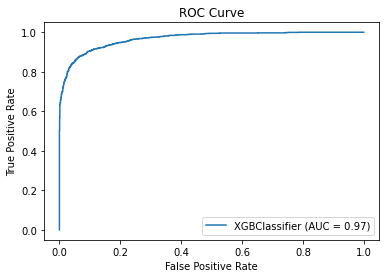

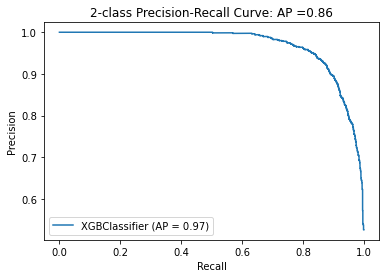

In [74]:
base_model = train_model(0, 3)


Accuracy: 96.75%


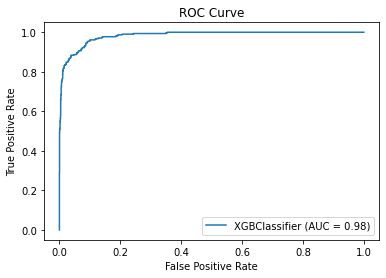

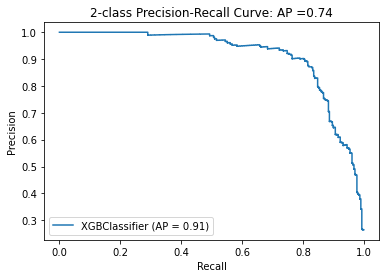

In [67]:
long_model = train_model(0, 10)

<BarContainer object of 41 artists>

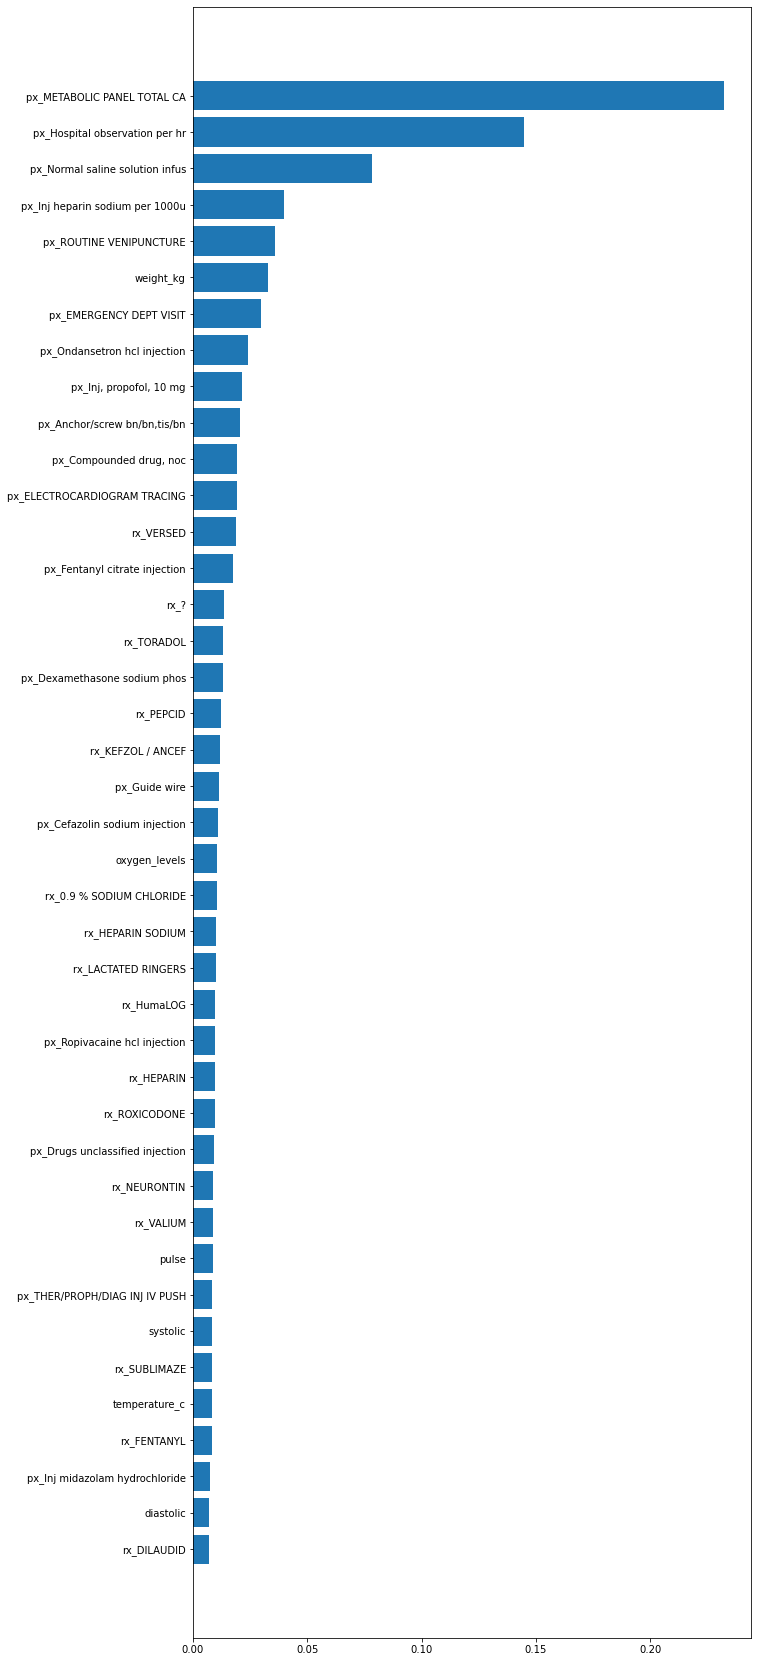

In [54]:
plt.figure(figsize=(10,30))
sorted_features = base_model.feature_importances_.argsort()
plt.barh(np.array(list(features_to_look_at))[sorted_features], base_model.feature_importances_[sorted_features])


Accuracy: 90.03%


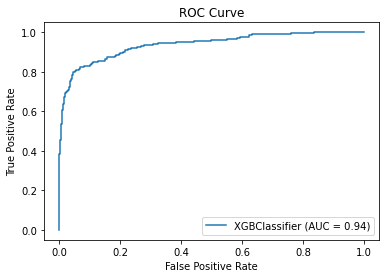

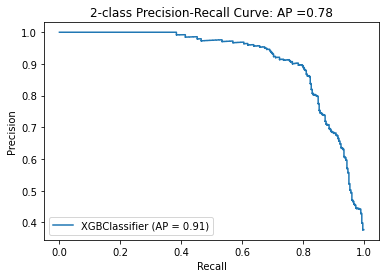

In [72]:
median_model = train_model(3, 7, max_depth=9)

In [ ]:
# For imbalanced problems (such as septic shock)
    # weigh the events
# Iterate 